<a href="https://colab.research.google.com/github/patbaa/demo_notebooks/blob/master/fully_connected_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.ensemble import RandomForestClassifier

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 0. load titanic

In [2]:
data = pd.read_csv('http://patbaa.web.elte.hu/titanic.csv')
data.drop(['Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [3]:
data.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [4]:
data[['C', 'Q', 'S']] = pd.get_dummies(data.Embarked, dummy_na=False)
data['miss_cabin'] = data.Cabin.isna().astype(int)
data['miss_age'] = data.Age.isna().astype(int)
data['Sex'] = [int(i == 'Male') for i in data.Sex.values]
data.Age.fillna(-1, inplace=True)

In [5]:
data.drop(['Cabin', 'Embarked'], axis=1, inplace=True)

In [6]:
data.isna().sum()

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
C             0
Q             0
S             0
miss_cabin    0
miss_age      0
dtype: int64

In [7]:
y = data.pop('Survived')

In [8]:
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S,miss_cabin,miss_age
0,3,0,22.0,1,0,7.2500,0,0,1,1,0
1,1,0,38.0,1,0,71.2833,1,0,0,0,0
2,3,0,26.0,0,0,7.9250,0,0,1,1,0
3,1,0,35.0,1,0,53.1000,0,0,1,0,0
4,3,0,35.0,0,0,8.0500,0,0,1,1,0


In [9]:
data['Age'] = (data.Age - data.Age.mean())/data.Age.std() 
data['Fare'] = (data.Fare - data.Fare.mean())/data.Fare.std() 

# 1. Perceptron wiht Sklearn

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

In [11]:
perc = Perceptron()
perc.fit(X_train, y_train)
preds = perc.decision_function(X_test)

decision_function(X)
Predict confidence scores for samples.  

The confidence score for a sample is the signed distance of that sample to the hyperplane.

### But for ROC we do not need probabilities, simply sorting the predictions by certainty is enough!

In [12]:
def plot_roc(y_score, y_true):
    fpr, tpr, _ = roc_curve(y_score=y_score, y_true=y_true)
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label='AUC: ' + str(np.round(roc_auc_score(y_score=y_score, y_true=y_true), 3)))
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.plot([-1, 2], [-1, 2], '--')
    plt.legend(fontsize=15)
    plt.show()

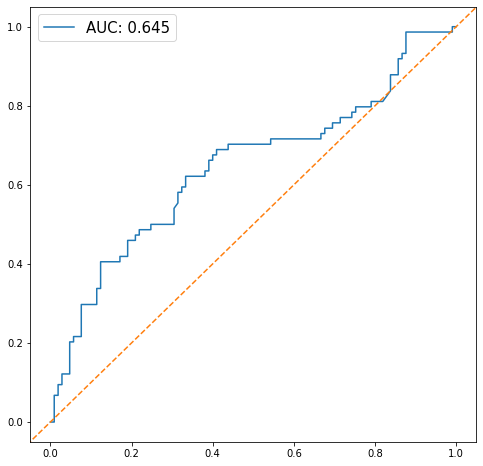

In [13]:
plot_roc(preds, y_test)

# 2. Multilayer perceptron in sklearn

In [14]:
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
MLPpreds = mlp.predict_proba(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


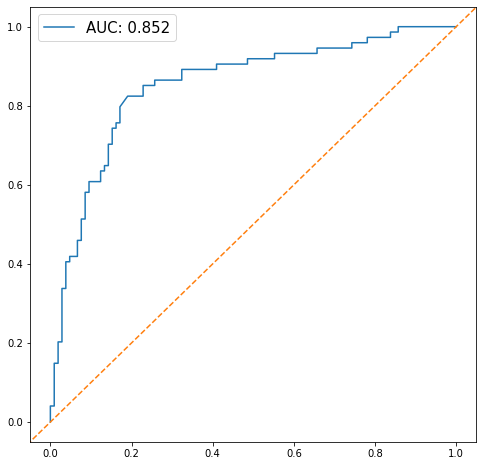

In [15]:
plot_roc(MLPpreds[:,1], y_test)

In [34]:
mlp

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

class sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', *, solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)[source]

# 3. Similar in tensorflow/keras

In [16]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=data.shape[1]))
model.add(Dense(1, activation='sigmoid'))

In [17]:
model.compile(optimizer=Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8), 
              metrics=['accuracy'], loss='binary_crossentropy')

In [18]:
len(data)/200

4.455

In [19]:
4*50

200

In [20]:
history = model.fit(X_train.values, y_train.values, batch_size=200, epochs = 50, 
                    validation_data = (X_test.values, y_test.values))

Epoch 1/50
4/4 [==============================] - 0s 34ms/step - loss: 0.6837 - accuracy: 0.5267 - val_loss: 0.6576 - val_accuracy: 0.6983
Epoch 2/50
4/4 [==============================] - 0s 6ms/step - loss: 0.6509 - accuracy: 0.6643 - val_loss: 0.6382 - val_accuracy: 0.6704
Epoch 3/50
4/4 [==============================] - 0s 5ms/step - loss: 0.6314 - accuracy: 0.6545 - val_loss: 0.6271 - val_accuracy: 0.6592
Epoch 4/50
4/4 [==============================] - 0s 5ms/step - loss: 0.6209 - accuracy: 0.6685 - val_loss: 0.6205 - val_accuracy: 0.6592
Epoch 5/50
4/4 [==============================] - 0s 5ms/step - loss: 0.6138 - accuracy: 0.6713 - val_loss: 0.6152 - val_accuracy: 0.6648
Epoch 6/50
4/4 [==============================] - 0s 6ms/step - loss: 0.6099 - accuracy: 0.6784 - val_loss: 0.6106 - val_accuracy: 0.6704
Epoch 7/50
4/4 [==============================] - 0s 6ms/step - loss: 0.6065 - accuracy: 0.6784 - val_loss: 0.6058 - val_accuracy: 0.6760
Epoch 8/50
4/4 [=================

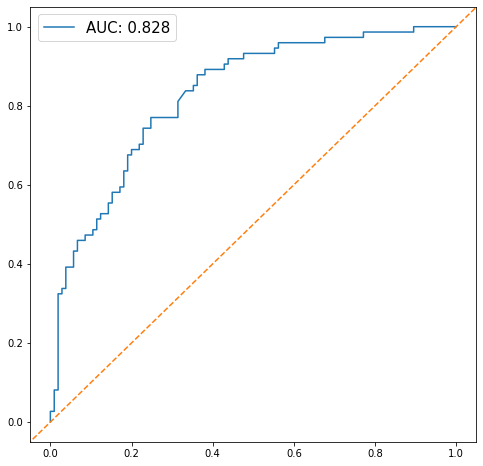

In [21]:
tf_preds = model.predict(X_test.values)
plot_roc(tf_preds, y_test)

# 4. MNIST

In [22]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 28*28)/255
x_test = x_test.reshape(10000, 28*28)/255

y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)

11493376/11490434 [==============================] - 0s 0us/step


In [23]:
%%time
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train_oh)
rf_preds = rf.predict(x_test)

CPU times: user 1min 2s, sys: 220 ms, total: 1min 2s
Wall time: 1min 2s


In [24]:
(rf_preds.argmax(1) == y_test).mean()

0.9062

In [25]:
model = Sequential()
model.add(Dense(784, activation='relu', input_dim=784))
model.add(Dense(784, activation='relu'))
model.add(Dense(784, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])
model.fit(x=x_train, y=y_train_oh, batch_size=256, epochs=15, validation_data=(x_test, y_test_oh))

Epoch 1/15
235/235 [==============================] - 1s 5ms/step - loss: 0.5157 - accuracy: 0.8717 - val_loss: 0.2046 - val_accuracy: 0.9425
Epoch 2/15
235/235 [==============================] - 1s 4ms/step - loss: 0.1729 - accuracy: 0.9500 - val_loss: 0.1431 - val_accuracy: 0.9594
Epoch 3/15
235/235 [==============================] - 1s 4ms/step - loss: 0.1210 - accuracy: 0.9651 - val_loss: 0.1114 - val_accuracy: 0.9678
Epoch 4/15
235/235 [==============================] - 1s 4ms/step - loss: 0.0921 - accuracy: 0.9736 - val_loss: 0.0981 - val_accuracy: 0.9686
Epoch 5/15
235/235 [==============================] - 1s 4ms/step - loss: 0.0724 - accuracy: 0.9794 - val_loss: 0.0789 - val_accuracy: 0.9759
Epoch 6/15
235/235 [==============================] - 1s 4ms/step - loss: 0.0573 - accuracy: 0.9835 - val_loss: 0.0783 - val_accuracy: 0.9757
Epoch 7/15
235/235 [==============================] - 1s 4ms/step - loss: 0.0461 - accuracy: 0.9871 - val_loss: 0.0752 - val_accuracy: 0.9771
Epoch 

# SGD small learning rate

In [26]:
model = Sequential()
model.add(Dense(784, activation='relu', input_dim=784))
model.add(Dense(784, activation='relu'))
model.add(Dense(784, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=5*1e-4), metrics=['accuracy'])
model.fit(x=x_train, y=y_train_oh, batch_size=256, epochs=15, validation_data=(x_test, y_test_oh))

Epoch 1/15
235/235 [==============================] - 1s 4ms/step - loss: 2.2790 - accuracy: 0.1529 - val_loss: 2.2443 - val_accuracy: 0.2478
Epoch 2/15
235/235 [==============================] - 1s 4ms/step - loss: 2.2133 - accuracy: 0.3379 - val_loss: 2.1786 - val_accuracy: 0.4346
Epoch 3/15
235/235 [==============================] - 1s 4ms/step - loss: 2.1493 - accuracy: 0.4913 - val_loss: 2.1125 - val_accuracy: 0.5607
Epoch 4/15
235/235 [==============================] - 1s 4ms/step - loss: 2.0834 - accuracy: 0.5912 - val_loss: 2.0434 - val_accuracy: 0.6334
Epoch 5/15
235/235 [==============================] - 1s 4ms/step - loss: 2.0138 - accuracy: 0.6515 - val_loss: 1.9696 - val_accuracy: 0.6800
Epoch 6/15
235/235 [==============================] - 1s 4ms/step - loss: 1.9393 - accuracy: 0.6880 - val_loss: 1.8905 - val_accuracy: 0.7107
Epoch 7/15
235/235 [==============================] - 1s 4ms/step - loss: 1.8593 - accuracy: 0.7137 - val_loss: 1.8057 - val_accuracy: 0.7299
Epoch 

# SGD too large learning rate

In [27]:
model = Sequential()
model.add(Dense(784, activation='relu', input_dim=784))
model.add(Dense(784, activation='relu'))
model.add(Dense(784, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=2), metrics=['accuracy'])
model.fit(x=x_train, y=y_train_oh, batch_size=256, epochs=15, validation_data=(x_test, y_test_oh))

Epoch 1/15
235/235 [==============================] - 1s 4ms/step - loss: nan - accuracy: 0.0997 - val_loss: nan - val_accuracy: 0.0980
Epoch 2/15
235/235 [==============================] - 1s 4ms/step - loss: nan - accuracy: 0.0987 - val_loss: nan - val_accuracy: 0.0980
Epoch 3/15
235/235 [==============================] - 1s 4ms/step - loss: nan - accuracy: 0.0987 - val_loss: nan - val_accuracy: 0.0980
Epoch 4/15
235/235 [==============================] - 1s 4ms/step - loss: nan - accuracy: 0.0987 - val_loss: nan - val_accuracy: 0.0980
Epoch 5/15
235/235 [==============================] - 1s 4ms/step - loss: nan - accuracy: 0.0987 - val_loss: nan - val_accuracy: 0.0980
Epoch 6/15
235/235 [==============================] - 1s 4ms/step - loss: nan - accuracy: 0.0987 - val_loss: nan - val_accuracy: 0.0980
Epoch 7/15
235/235 [==============================] - 1s 4ms/step - loss: nan - accuracy: 0.0987 - val_loss: nan - val_accuracy: 0.0980
Epoch 8/15
235/235 [============================

In [28]:
model.weights[-1]

<tf.Variable 'dense_13/bias:0' shape=(10,) dtype=float32, numpy=array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)>

In [29]:
model.weights[0]

<tf.Variable 'dense_10/kernel:0' shape=(784, 784) dtype=float32, numpy=
array([[        nan,  0.01881481, -0.01887582, ...,         nan,
         0.04493736,  0.01802251],
       [        nan,  0.0415997 , -0.02803978, ...,         nan,
         0.0340055 ,  0.00604189],
       [        nan,  0.05375856, -0.04891065, ...,         nan,
        -0.01477888, -0.02304473],
       ...,
       [        nan, -0.06115225, -0.00456145, ...,         nan,
        -0.04773515, -0.02783428],
       [        nan, -0.03128678, -0.05959795, ...,         nan,
         0.01051067, -0.02181698],
       [        nan,  0.00169967, -0.02093336, ...,         nan,
        -0.04438247,  0.05233732]], dtype=float32)>

# What if there is no scaling?

In [30]:
model = Sequential()
model.add(Dense(784, activation='relu', input_dim=784))
model.add(Dense(784, activation='relu'))
model.add(Dense(784, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=1e-1), metrics=['accuracy'])
history = model.fit(x=x_train, y=y_train_oh, batch_size=256, epochs=5, validation_data=(x_test, y_test_oh))

Epoch 1/5
235/235 [==============================] - 1s 4ms/step - loss: 0.5267 - accuracy: 0.8555 - val_loss: 0.5495 - val_accuracy: 0.8189
Epoch 2/5
235/235 [==============================] - 1s 4ms/step - loss: 0.2219 - accuracy: 0.9355 - val_loss: 0.1888 - val_accuracy: 0.9441
Epoch 3/5
235/235 [==============================] - 1s 4ms/step - loss: 0.1635 - accuracy: 0.9524 - val_loss: 0.1388 - val_accuracy: 0.9576
Epoch 4/5
235/235 [==============================] - 1s 4ms/step - loss: 0.1295 - accuracy: 0.9624 - val_loss: 0.1456 - val_accuracy: 0.9557
Epoch 5/5
235/235 [==============================] - 1s 4ms/step - loss: 0.1065 - accuracy: 0.9689 - val_loss: 0.1178 - val_accuracy: 0.9622


# Overfitting

In [31]:
model = Sequential()
model.add(Dense(784, activation='relu', input_dim=784))
model.add(Dense(784, activation='relu'))
model.add(Dense(784, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=1e-1), metrics=['accuracy'])
model.fit(x=x_train*255, y=y_train_oh, batch_size=256, epochs=5, validation_data=(x_test*255, y_test_oh))

Epoch 1/5
235/235 [==============================] - 1s 4ms/step - loss: nan - accuracy: 0.0988 - val_loss: nan - val_accuracy: 0.0980
Epoch 2/5
235/235 [==============================] - 1s 4ms/step - loss: nan - accuracy: 0.0987 - val_loss: nan - val_accuracy: 0.0980
Epoch 3/5
235/235 [==============================] - 1s 4ms/step - loss: nan - accuracy: 0.0987 - val_loss: nan - val_accuracy: 0.0980
Epoch 4/5
235/235 [==============================] - 1s 4ms/step - loss: nan - accuracy: 0.0987 - val_loss: nan - val_accuracy: 0.0980
Epoch 5/5
235/235 [==============================] - 1s 4ms/step - loss: nan - accuracy: 0.0987 - val_loss: nan - val_accuracy: 0.0980


# Is it overfitting? 

In [32]:
model = Sequential()
model.add(Dense(1096, activation='relu', input_dim=784))
model.add(Dense(1096, activation='relu'))
model.add(Dense(1096, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=1e-2), metrics=['accuracy'])
history = model.fit(x=x_train[:256], y=y_train_oh[:256], 
                     batch_size=16, epochs=50, validation_data=(x_test[:256], y_test_oh[:256]), verbose=0)

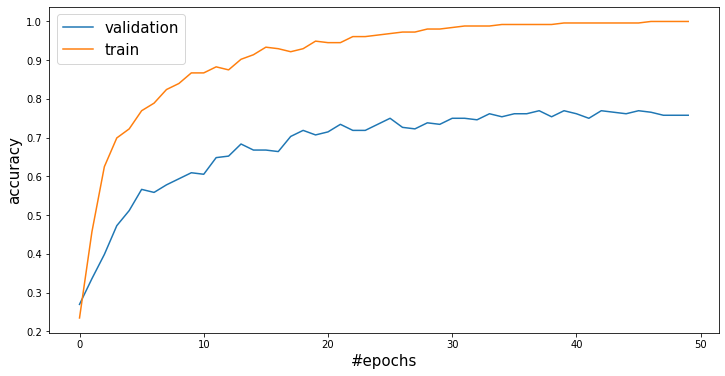

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['val_accuracy'], label='validation')
plt.plot(history.history['accuracy'], label='train')
plt.xlabel('#epochs', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.legend(fontsize=15)
plt.show()

# Recipe for training NN's by Karpathy

http://karpathy.github.io/2019/04/25/recipe/